In [1]:
%retina

UsageError: Line magic function `%retina` not found.


In [1]:
cd /private/home/jeanremi/project/jrr/code/meg_experiment

/private/home/jeanremi/project/jrr/code/meg_experiment


In [7]:
%matplotlib inline

import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import time
import submitit
from scipy.stats import wilcoxon
import seaborn as sns
import pandas as pd
import mne
from copy import deepcopy

from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_1samp, wilcoxon
import spacy

#from models import Forward, Backward, B2B, CCA, PLS, RegCCA, GridCCA, GridPLS, GridRegCCA, score_knockout
from common import log_files, data_path
from base import fetch_data

In [43]:
# models.py
import numpy as np
from scipy import linalg
from copy import deepcopy
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA as SkCCA
from sklearn.cross_decomposition import PLSRegression as SkPLS
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.linear_model import LinearRegression, RidgeCV

import warnings
warnings.simplefilter("ignore")

alphas = np.logspace(-4, 4, 20)
components = np.linspace(0., 1., 20)


def r_score(X, Y, multioutput='uniform_average'):
    """column-wise correlation coefficients"""

    assert multioutput in ('raw', 'raw_values', 'uniform_average',
                           'variance_weighted')
    if X.ndim == 1:
        X = X[:, None]
    if Y.ndim == 1:
        Y = Y[:, None]
    assert len(X) >= 2
    np.testing.assert_equal(X.shape, Y.shape)

    R = np.zeros(X.shape[1])
    for idx, (x, y) in enumerate(zip(X.T, Y.T)):
        R[idx] = pearsonr(x, y)[0]

    if multioutput == 'uniform_average':
        R = R.mean()
    elif multioutput == 'variance_weighted':
        std = np.r_[X, Y].std(0)
        R = np.average(R, weights=std)
    return R


def rn_score(X, Y, scoring='r', multioutput='uniform_average'):
    assert scoring in ('r', 'r2')
    assert multioutput in ('raw', 'raw_values',
                           'uniform_average', 'variance_weighted')

    if scoring == 'r':
        return r_score(X, Y, multioutput=multioutput)

    elif scoring == 'r2':
        return r2_score(X, Y, multioutput=multioutput)


class B2B(BaseEstimator, RegressorMixin):
    def __init__(self, alphas=alphas,
                 independent_alphas=True, ensemble=None,
                 G='ridge_cv',
                 H='ridge_cv',
                 scoring='r'):
        self.alphas = alphas
        self.independent_alphas = independent_alphas
        self.ensemble = ensemble
        self.scoring = scoring
        self.__name__ = 'B2B'
        self.G = G
        self.H = H

    def fit(self, X, Y):
        import copy

        self.G_ = list()
        self.H_ = list()

        # Prepare ensembling
        if self.ensemble is None:
            ensemble = [(range(len(X)), range(len(X))), ]
        else:
            if isinstance(self.ensemble, int):
                ensemble = ShuffleSplit(self.ensemble)
            else:
                ensemble = self.ensemble
            ensemble = [split for split in ensemble.split(X)]

        # Ensembling loop
        for train, test in ensemble:

            # Fit decoder
            if self.G == 'ridge_cv':
                G, G_alpha, YG = ridge_cv(Y[train], X[train],
                                          self.alphas,
                                          self.independent_alphas)
                if len(X[train]) != len(X):
                    YG = Y @ G.T
            else:
                G = copy.deepcopy(self.G).fit(Y[train], X[train])
                YG = np.empty((len(Y), X.shape[1]))
                YG[test] = G.predict(Y[test])

            self.G_.append(G)


            # Fit encoder
            if self.H == 'ridge_cv':
                H, H_alpha, _ = ridge_cv(X[test], YG[test],
                                         self.alphas,
                                         self.independent_alphas)
            else:
                H = copy.deepcopy(self.H).fit(X[test], YG[test])
            self.H_.append(H)

        # Aggregate ensembling
        if self.G == 'ridge_cv':
            self.G_ = np.mean(self.G_, 0)
        if self.H == 'ridge_cv':
            self.H_ = np.mean(self.H_, 0)
        self.E_ = np.diag(self.H_)

        return self

    def fit_H(self, X, Y):

        assert hasattr(self, 'G_')

        YG = Y @ self.G_.T
        # Fit encoder
        if self.H == 'ridge_cv':
            self.H_, H_alpha, _ = ridge_cv(X, YG,
                                           self.alphas,
                                           self.independent_alphas)
        else:
            raise NotImplementedError


        # Aggregate ensembling
        self.E_ = np.diag(self.H_)
        return self

    def score(self, X, Y, scoring=None, multioutput='raw_values'):
        scoring = self.scoring if scoring is None else scoring
        if multioutput != 'raw_values':
            raise NotImplementedError
        if self.G == 'ridge_cv':
            # Transform with decoder
            YG = Y @ self.G_.T
        else:
            YG = np.mean([G.predict(Y) for G in self.G_], 0)
            
        # Make standard and knocked-out encoders predictions
        if self.H == 'ridge_cv':
            XH = X @ self.H_.T
        else:
            XH = np.mean([H.predict(X) for H in self.H_], 0)
        # Compute R for each column X
        return rn_score(YG, XH, 
                        scoring=scoring, multioutput='raw_values')


class UnbiasedB2B(B2B):

    def fit(self, X, Y):

        self.G_ = list()
        self.H_ = list()

        # Prepare ensembling
        if self.ensemble is None:
            ensemble = [(range(len(X)), range(len(X))), ]
        else:
            if isinstance(self.ensemble, int):
                ensemble = ShuffleSplit(self.ensemble)
            else:
                ensemble = self.ensemble
            ensemble = [split for split in ensemble.split(X)]

        # Ensembling loop
        ols = LinearRegression()
        for train, test in ensemble:

            # Fit decoder
            G, G_alpha, YG = ridge_cv(Y[train], X[train],
                                      self.alphas,
                                      self.independent_alphas)
            self.G_.append(G)

            # Fit encoder
            H = ols.fit(X[test], Y[test] @ G.T).coef_
            self.H_.append(H)

        # Aggregate ensembling
        self.G_ = np.mean(self.G_, 0)
        self.H_ = np.mean(self.H_, 0)
        self.E_ = np.diag(self.H_)

        return self

    def score(self, X, Y, scoring=None, multioutput='raw_values'):
        scoring = self.scoring if scoring is None else scoring
        if multioutput != 'raw_values':
            raise NotImplementedError
        # Transform with decoder
        YG = Y @ self.G_.T
        # Make standard and knocked-out encoders predictions
        XE = X @ np.diag(self.E_).T
        # Compute R for each column X
        return rn_score(YG, XE, scoring=scoring, multioutput='raw_values')

    
def ridge_cv(X, Y, alphas, independent_alphas=False, Uv=None):
    """ Similar to sklearn RidgeCV but
   (1) can optimize a different alpha for each column of Y
   (2) return leave-one-out Y_hat
   """
    if isinstance(alphas, (float, int)):
        alphas = np.array([alphas, ], np.float64)
    if Y.ndim == 1:
        Y = Y[:, None]
    n, n_x = X.shape
    n, n_y = Y.shape
    # Decompose X
    if Uv is None:
        U, s, _ = linalg.svd(X, full_matrices=0)
        v = s**2
    else:
        U, v = Uv
    UY = U.T @ Y

    # For each alpha, solve leave-one-out error coefs
    cv_duals = np.zeros((len(alphas), n, n_y))
    cv_errors = np.zeros((len(alphas), n, n_y))
    for alpha_idx, alpha in enumerate(alphas):
        # Solve
        w = ((v + alpha) ** -1) - alpha ** -1
        c = U @ np.diag(w) @ UY + alpha ** -1 * Y
        cv_duals[alpha_idx] = c

        # compute diagonal of the matrix: dot(Q, dot(diag(v_prime), Q^T))
        G_diag = (w * U ** 2).sum(axis=-1) + alpha ** -1
        error = c / G_diag[:, np.newaxis]
        cv_errors[alpha_idx] = error

    # identify best alpha for each column of Y independently
    if independent_alphas:
        best_alphas = (cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = np.transpose([cv_duals[b, :, i]
                              for i, b in enumerate(best_alphas)])
        cv_errors = np.transpose([cv_errors[b, :, i]
                                  for i, b in enumerate(best_alphas)])
    else:
        _cv_errors = cv_errors.reshape(len(alphas), -1)
        best_alphas = (_cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = cv_duals[best_alphas]
        cv_errors = cv_errors[best_alphas]

    coefs = duals.T @ X
    Y_hat = Y - cv_errors
    return coefs, best_alphas, Y_hat


class Forward():
    def __init__(self, alphas=alphas, independent_alphas=True,
                 scoring='r', multioutput='uniform_average'):
        self.alphas = alphas
        self.independent_alphas = independent_alphas
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'Forward'

    def fit(self, X, Y):
        # Fit encoder
        self.H_, H_alpha, _ = ridge_cv(X, Y, self.alphas,
                                       self.independent_alphas)

        self.E_ = np.sum(self.H_**2, 0)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        # Make standard and knocked-out encoders predictions
        XH = X @ self.H_.T
        # Compute R for each column of Y
        return rn_score(Y, XH, scoring=scoring, multioutput=multioutput)

    def predict(self, X):
        return X @ self.H_.T


class Backward():
    def __init__(self, alphas=alphas, independent_alphas=True,
                 scoring='r'):
        self.alphas = alphas
        self.independent_alphas = independent_alphas
        self.scoring = scoring
        self.__name__ = 'Backward'

    def fit(self, X, Y):
        # Fit encoder
        self.H_, H_alpha, _ = ridge_cv(Y, X, self.alphas,
                                       self.independent_alphas)

        self.E_ = np.sum(self.H_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput='raw_values'):
        scoring = self.scoring if scoring is None else scoring
        if multioutput != 'raw_values':
            raise NotImplementedError
        # Make standard and knocked-out encoders predictions
        YH = Y @ self.H_.T
        # Compute R for each column of Y
        return rn_score(X, YH, scoring=scoring, multioutput=multioutput)

    def predict(self, X):
        return 0


def canonical_correlation(model, X, Y, scoring, multioutput):
    """Score in canonical space"""

    # check valid model
    for xy in 'xy':
        for var in ('mean', 'std', 'rotations'):
            assert hasattr(model, '%s_%s_' % (xy, var))
    assert model.x_rotations_.shape[1] == model.y_rotations_.shape[1]

    # check valid data
    if Y.ndim == 1:
        Y = Y[:, None]
    if X.ndim == 1:
        X = X[:, None]
    assert len(X) == len(Y)

    # Project to canonical space
    X = X - model.x_mean_
    X /= model.x_std_
    X = np.nan_to_num(X, 0)
    XA = X @ model.x_rotations_

    Y = Y - model.y_mean_
    Y /= model.y_std_
    Y = np.nan_to_num(Y, 0)
    YB = Y @ model.y_rotations_

    return rn_score(XA, YB, scoring=scoring, multioutput=multioutput)


def validate_number_components(n, X, Y):
    n_max = min(X.shape[1], Y.shape[1])
    if n == -1:
        n = n_max
    elif n >= 0. and n < 1.:
        n = int(np.floor(n_max * n))
        n = 1 if n == 0 else n

    assert n == int(n) and n > 0 and n <= n_max
    return int(n)


class GridPLS(BaseEstimator, RegressorMixin):
    """Optimize n_components by minimizing Y_pred error"""
    def __init__(self, n_components=components, cv=5,
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.n_components = n_components
        self.cv = cv
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'GridPLS'

    def fit(self, X, Y):

        N = self.n_components
        if not isinstance(N, (list, np.ndarray)):
            N = [N, ]

        components = np.unique([validate_number_components(n, X, Y)
                                for n in N])
        # Optimize n_components on Y prediction!
        if len(components) > 1:
            models = GridSearchCV(SkPLS(), dict(n_components=components))
            best = models.fit(X, Y).best_estimator_
            self.n_components_ = best.n_components

            x_valid = range(X.shape[1])
            y_valid = range(Y.shape[1])
        else:
            best = PLS(n_components=components[0],
                       scoring=self.scoring,
                       multioutput=self.multioutput)
            best.fit(X, Y)
            self.n_components_ = best.n_components_
            x_valid = best.x_valid_
            y_valid = best.y_valid_

        self.x_mean_ = np.zeros(X.shape[1])
        self.x_std_ = np.zeros(X.shape[1])
        self.x_rotations_ = np.zeros((X.shape[1], self.n_components_))
        self.y_mean_ = np.zeros(Y.shape[1])
        self.y_std_ = np.zeros(Y.shape[1])
        self.y_rotations_ = np.zeros((Y.shape[1], self.n_components_))

        self.x_mean_[x_valid] = best.x_mean_
        self.x_std_[x_valid] = best.x_std_
        self.x_rotations_[x_valid, :] = best.x_rotations_
        self.y_mean_[y_valid] = best.y_mean_
        self.y_std_[y_valid] = best.y_std_
        self.y_rotations_[y_valid, :] = best.y_rotations_

        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)
    def transform(self, X):
        return self.best.transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).best.transform(X)


class GridCCA(BaseEstimator, RegressorMixin):
    """Optimize n_components by minimizing Y_pred error"""
    def __init__(self, n_components=components, cv=5,
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.n_components = n_components
        self.cv = cv
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'GridCCA'

    def fit(self, X, Y):

        N = self.n_components
        if not isinstance(N, (list, np.ndarray)):
            N = [N, ]
        components = np.unique([validate_number_components(n, X, Y)
                                for n in N])
        # Optimize n_components on Y prediction!
        if len(components) > 1:
            models = GridSearchCV(SkCCA(), dict(n_components=components))
            best = models.fit(X, Y).best_estimator_
            self.n_components_ = best.n_components
            x_valid = range(X.shape[1])
            y_valid = range(Y.shape[1])
        else:
            best = CCA(n_components=components[0],
                       scoring=self.scoring,
                       multioutput=self.multioutput)
            best.fit(X, Y)
            self.n_components_ = best.n_components_

            x_valid = best.x_valid_
            y_valid = best.y_valid_

        self.x_mean_ = np.zeros(X.shape[1])
        self.x_std_ = np.zeros(X.shape[1])
        self.x_rotations_ = np.zeros((X.shape[1], self.n_components_))
        self.y_mean_ = np.zeros(Y.shape[1])
        self.y_std_ = np.zeros(Y.shape[1])
        self.y_rotations_ = np.zeros((Y.shape[1], self.n_components_))

        self.x_mean_[x_valid] = best.x_mean_
        self.x_std_[x_valid] = best.x_std_
        self.x_rotations_[x_valid, :] = best.x_rotations_
        self.y_mean_[y_valid] = best.y_mean_
        self.y_std_[y_valid] = best.y_std_
        self.y_rotations_[y_valid, :] = best.y_rotations_

        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)
    def transform(self, X):
        return self.best.transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).best.transform(X)


class GridRegCCA(BaseEstimator, RegressorMixin):
    def __init__(self, alphas=np.logspace(-4, 4., 20), cv=5,
                 n_components=[-1, ],
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.alphas = alphas
        self.cv = cv
        self.scoring = scoring
        self.n_components = n_components
        self.multioutput = multioutput
        self.__name__ = 'GridRegCCA'

    def fit(self, X, Y):

        self.x_valid_ = np.where(X.std(0) > 0)[0]
        self.y_valid_ = np.where(Y.std(0) > 0)[0]
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]

        N = self.n_components
        if not isinstance(N, (list, np.ndarray)):
            N = [N, ]
        components = np.unique([validate_number_components(n, X, Y)
                                for n in N])
        grid = {'alpha': self.alphas,
                'n_components': components}

        # Optimize n_components on Y prediction!
        if np.prod(list(map(np.shape, grid.values()))) > 1:
            models = GridSearchCV(RegCCA(scoring=self.scoring,
                                         multioutput=self.multioutput),
                                  grid)
            best = models.fit(X, Y).best_estimator_
        else:
            best = RegCCA(alpha=grid['alpha'][0], n_components=components[0],
                          scoring=self.scoring, multioutput=self.multioutput)
            best.fit(X, Y)
        self.n_components_ = best.n_components
        self.alpha_ = best.alpha

        self.x_mean_ = best.x_mean_
        self.x_std_ = best.x_std_
        self.x_rotations_ = best.x_rotations_
        self.y_mean_ = best.y_mean_
        self.y_std_ = best.y_std_
        self.y_rotations_ = best.y_rotations_

        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):

        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)

    def transform(self, X):
        return self.best.transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).best.transform(X)

class CCA(SkCCA):
    """overwrite scikit-learn CCA to get scoring function in
       canonical space"""

    def __init__(self, n_components=-1,
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'CCA'
        super().__init__(n_components=n_components, tol=tol)

    def fit(self, X, Y):

        self.x_valid_ = np.where(X.std(0) > 0)[0]
        self.y_valid_ = np.where(Y.std(0) > 0)[0]
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]

        N = self.n_components
        self.n_components = validate_number_components(N, X, Y)
        super().fit(X, Y)
        self.n_components_ = self.n_components
        self.n_components = N
        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)

    def transform(self, X):
        return super().transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).transform(X)

    
class PLS(SkPLS):
    """overwrite scikit-learn PLSRegression to get scoring function in
       canonical space"""

    def __init__(self, n_components=-1,
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'PLS'
        super().__init__(n_components=n_components, tol=tol)

    def fit(self, X, Y):
        self.x_valid_ = np.where(X.std(0) > 0)[0]
        self.y_valid_ = np.where(Y.std(0) > 0)[0]
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]
        N = self.n_components
        self.n_components = validate_number_components(N, X, Y)
        super().fit(X, Y)
        self.n_components_ = self.n_components
        self.n_components = N
        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)

    def transform(self, X):
        return super().transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).transform(X)


class RegCCA(CCA):
    """Wrapper to get sklearn API for Regularized CCA """
    def __init__(self, alpha=0., n_components=-1,
                 scoring='r', multioutput='uniform_average',
                 tol=1e-15):
        self.alpha = alpha
        self.n_components = n_components
        assert (n_components > 0) or (n_components == -1)
        self.tol = tol
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'RegCCA'

    def fit(self, X, Y):

        self.x_valid_ = np.where(X.std(0) > 0)[0]
        self.y_valid_ = np.where(Y.std(0) > 0)[0]
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]

        # Set truncation
        dx, dy = X.shape[1], Y.shape[1]
        dz_max = min(dx, dy)
        dz = dz_max if self.n_components == -1 else self.n_components
        dz = min(dz, dz_max)
        self.n_components_ = dz
        self.x_rotations_ = np.zeros((dx, dz))
        self.y_rotations_ = np.zeros((dy, dz))

        # Preprocess
        self.x_std_ = X.std(0)
        self.y_std_ = Y.std(0)
        self.x_mean_ = X.mean(0)
        self.y_mean_ = Y.mean(0)

        X = (X - self.x_mean_) / self.x_std_
        Y = (Y - self.y_mean_) / self.y_std_

        # compute cca
        comps = self._compute_kcca([X, Y],
                                   reg=self.alpha, numCC=dz)
        self.x_rotations_ = comps[0]
        self.y_rotations_ = comps[1]
        self.E_ = np.sum(self.x_rotations_**2, 1)

        return self

    def _compute_kcca(self, data, reg=0., numCC=None):
        """Adapted from https://github.com/gallantlab/pyrcca

        Copyright (c) 2015, The Regents of the University of California
        (Regents). All rights reserved.

        Permission to use, copy, modify, and distribute this software and its
        documentation for educational, research, and not-for-profit purposes,
        without fee and without a signed licensing agreement, is hereby
        granted, provided that the above copyright notice, this paragraph and
        the following two paragraphs appear in all copies, modifications, and
        distributions. Contact The Office of Technology Licensing, UC Berkeley,
        2150 Shattuck Avenue, Suite 510, Berkeley, CA 94720-1620, (510)
        643-7201, for commercial licensing opportunities.

        Created by Natalia Bilenko, University of California, Berkeley.
        """

        kernel = [d.T for d in data]

        nDs = len(kernel)
        nFs = [k.shape[0] for k in kernel]
        numCC = min([k.shape[1] for k in kernel]) if numCC is None else numCC

        # Get the auto- and cross-covariance matrices
        crosscovs = [np.dot(ki, kj.T) for ki in kernel for kj in kernel]

        # Allocate left-hand side (LH) and right-hand side (RH):
        LH = np.zeros((sum(nFs), sum(nFs)))
        RH = np.zeros((sum(nFs), sum(nFs)))

        # Fill the left and right sides of the eigenvalue problem
        for i in range(nDs):
            RH[sum(nFs[:i]): sum(nFs[:i+1]),
               sum(nFs[:i]): sum(nFs[:i+1])] = (crosscovs[i * (nDs + 1)]
                                                + reg * np.eye(nFs[i]))

            for j in range(nDs):
                if i != j:
                    LH[sum(nFs[:j]): sum(nFs[:j+1]),
                       sum(nFs[:i]): sum(nFs[:i+1])] = crosscovs[nDs * j + i]

        LH = (LH + LH.T) / 2.
        RH = (RH + RH.T) / 2.

        maxCC = LH.shape[0]
        try:
            r, Vs = linalg.eigh(LH, RH, eigvals=(maxCC - numCC, maxCC - 1))
        except linalg.LinAlgError:  # noqa
            r = np.zeros(numCC)
            Vs = np.zeros((sum(nFs), numCC))

        r[np.isnan(r)] = 0
        rindex = np.argsort(r)[::-1]
        comp = []
        Vs = Vs[:, rindex]
        for i in range(nDs):
            comp.append(Vs[sum(nFs[:i]):sum(nFs[:i + 1]), :numCC])
        return comp


def score_knockout(model, X, Y, XY_train=None, scoring='r', fix_grid=True):
    assert isinstance(model, (CCA, PLS, GridCCA, GridPLS, RegCCA,
                              GridRegCCA, B2B, Forward, Backward))
    assert len(X) == len(Y)
    assert scoring in ('r', 'r2')
    is_b2b = isinstance(model, B2B)
    dim_x = X.shape[1]

    # Compute standard scores
    score_full = model.score(X, Y,
                             scoring=scoring,
                             multioutput='raw_values')
    score_delta = np.zeros(dim_x)

    # Compute knock out scores
    for f in range(dim_x):

        # Setup knockout matrix
        knockout = np.eye(dim_x)
        knockout[f] = 0

        model_ = model
        # refit the model
        if XY_train is not None:
            X_train, Y_train = XY_train
            model_ = deepcopy(model)
            if isinstance(model, (GridPLS, GridCCA, GridRegCCA)) and fix_grid:
                n = model.n_components_
                model_.n_components = -1 if n == X.shape[1] else n
            if is_b2b:
                model_.fit_H(X_train @ knockout, Y_train)
            else:
                model_.fit(X_train @ knockout, Y_train)

        # Score
        score_ko = model_.score(X @ knockout, Y,
                                scoring=scoring,
                                multioutput='raw_values')

        # Aggregate predicted dimensions
        if is_b2b:
            score_delta[f] = score_full[f] - score_ko[f]
        elif len(score_full) != len(score_ko):
            print('Different dims!')
            score_delta[f] = score_full.mean() - score_ko.mean()
        else:
            score_delta[f] = (score_full - score_ko).mean()

    return score_delta


class Manova():
    def __init__(self, statistics='F Value'):
        self.statistics = statistics
    
    def fit(self, X, Y):
        from statsmodels.multivariate.manova import MANOVA
        model = MANOVA(Y, X)
        manova_results = model.mv_test().summary_frame.reset_index()
        idx = manova_results.Statistic == "Wilks' lambda"
        self.coef_ = np.array([v for v in manova_results.loc[idx, 'F Value'].values])



class Composite():
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, Y):
        self.models_ = list()
        for y, model in zip(Y.T, self.models):
            self.models_.append(model.fit(X, y))
        return self

    def predict(self, X):
        Y_pred = [model.predict(X) for model in self.models_]
        return np.transpose(Y_pred)
    
def get_model(model_name, n_features, n_voxels):
    

    max_comp = min(n_voxels, n_features)
    comp_sweep = np.unique(np.floor(np.linspace(1, max_comp, 20))).astype(int)
    alpha_sweep = np.logspace(-4, 4, 20)
    models = dict(
        B2B=B2B(alpha_sweep),
        B2B_ensemble=B2B(alpha_sweep, ensemble=20),
        UnbiasedB2B=UnbiasedB2B(alpha_sweep, ensemble=KFold(3, shuffle=False)),  # FIXME use b2b H=LinearRegregrssion
        UnbiasedB2B_ensemble=UnbiasedB2B(alpha_sweep, ensemble=20),  # FIXME use b2b H=LinearRegregrssion
        Backward=Backward(alpha_sweep),
        Forward=Forward(alpha_sweep),
        CCA=GridCCA(comp_sweep),
        RegCCA=GridRegCCA(alpha_sweep, n_components=[max_comp]),
        PLS=GridPLS(comp_sweep),
        B2B_CCALinearSVR=B2B(alpha_sweep,
                             G=make_pipeline(CCA(4), Composite([LinearSVR() for i in range(5)]))),
        B2B_CCASVR=B2B(G=make_pipeline(CCA(4), Composite([SVR() for i in range(5)])))
    )
    return models[model_name]
    
# if __name__ == '__main__':

#     X = np.zeros((10, 100))
#     Y = np.zeros((10, 200))
#     assert validate_number_components(0, X, Y) == 1
#     assert validate_number_components(1, X, Y) == 1
#     assert validate_number_components(.5, X, Y) == 50

#     def make_data():
#         n = 1000
#         dx = 4
#         dy = 5
#         X = np.random.randn(n, dx)
#         E = np.eye(dx)
#         E[2:] = 0
#         N = np.random.randn(n, dx)
#         N2 = np.random.randn(n, dy) / 10.
#         F = np.random.randn(dx, dy)
#         Y = (X @ E + N) @ F + N2

#         train, test = range(0, n, 2), range(1, n, 2)
#         return X, Y, train, test

#     X, Y, train, test = make_data()

#     models = (B2B, Forward, Backward, CCA, RegCCA, PLS,
#               GridCCA, GridPLS, GridRegCCA)
#     canonicals = (CCA, RegCCA, PLS, GridCCA, GridPLS, GridRegCCA)

#     for scoring in ('r', 'r2'):
#         for mo in ('uniform_average', 'variance_weighted'):
#             params = dict(scoring=scoring, multioutput=mo)

#             for model in models:
#                 if model in (B2B, Backward):
#                     model = model(scoring=scoring)
#                 else:
#                     model = model(scoring=scoring, multioutput=mo)
#                 model.fit(X[train], Y[train])
#                 assert len(model.E_) == X.shape[1]
#                 score = model.score(X[test], Y[test], multioutput='raw_values')

#                 if isinstance(model, canonicals):
#                     assert len(score) == model.n_components_
#                 elif isinstance(model, (B2B, Backward)):
#                     assert len(score) == X.shape[1]
#                 elif isinstance(model, Forward):
#                     assert len(score) == Y.shape[1]

#                 for fix_grid in (False, True):
#                     # assert np.mean(score) > .3
#                     score_delta = score_knockout(model, X[test], Y[test],
#                                                  scoring=scoring,
#                                                  fix_grid=fix_grid)
#                     assert len(score_delta) == X.shape[1]
#                     print(model.__name__, score_delta)
#                     score_delta = score_knockout(model, X[test], Y[test],
#                                                  (X[train], Y[train]),
#                                                  scoring=scoring,
#                                                  fix_grid=fix_grid)
#                     assert len(score_delta) == X.shape[1]
#                     print(model.__name__, score_delta)

#     for model in canonicals:
#         for n_components in (-1, 1, 2):
#             if model in (CCA, RegCCA, PLS):
#                 m = model(n_components)
#             else:
#                 m = model([n_components, ])
#             m.fit(X[train], Y[train])
#             assert len(m.E_) == X.shape[1]
#             score = m.score(X[test], Y[test], multioutput='raw_values')
#             assert len(score) == m.n_components_
#             print(model.__name__, score_delta)

In [9]:
import warnings
warnings.simplefilter("ignore")

In [10]:
log_files = log_files.query('task=="visual"')
print(len(log_files))

100


In [11]:
def load_all(folder='jrr_iclr'):
    """Loop Granger score for each time sample independently"""
    
    X = list()
    Y = list()
    for _, subject in log_files.iterrows():
        print('.', end='')
        # Paths
        preproc_path = op.join(data_path, '..', folder, 
                               '%s-preproc.pkl' % subject.subject)

        # Load and preprocess data
        if not op.isfile(preproc_path):
            continue
            
        with open(preproc_path, 'rb') as f:
            meg, times, features, names, words = pickle.load(f)
        
        t400 = np.where(times>.400)[0][0]
        X.append(features)
        Y.append(meg[:, :, t400])
    
    return X, Y

In [63]:
def run(subject, model_name,
        folder='jrr_iclr', refit_knockout=False,
        word_emb=False):
    """Loop Granger score for each time sample independently"""
    start = time.time()
    print(start)
    
    # Paths
    preproc_path = op.join(data_path, '..', folder, 
                           '%s-preproc.pkl' % subject.subject)
    
    # Load and preprocess data
    if op.isfile(preproc_path):
        with open(preproc_path, 'rb') as f:
            meg, times, features, names, words = pickle.load(f)
    else:
        meg, times, features, names, words = fetch_data(subject)
        with open(preproc_path, 'wb') as f:
            pickle.dump([meg, times, features, names, words], f)
    
    cv = KFold(5, shuffle=True)    
    n_features = features.shape[1]
    _, n_channels, n_times = meg.shape
    
    if word_emb:
        nlp = spacy.load('nl_core_news_sm')
        embedding = scale([w.vector[:10] for w in map(nlp, words.values)])
        features = np.c_[features, embedding]
        n_features = features.shape[1]
    
    # Prepare model
    max_comp = min(meg.shape[1], n_features)
    comp_sweep = np.unique(np.floor(np.linspace(1, max_comp, 20))).astype(int)
    alpha_sweep = np.logspace(-4, 4, 20)

    models = dict(B2B=B2B(alpha_sweep),
                  B2B_ensemble=B2B(alpha_sweep, ensemble=20),
                  Backward=Backward(alpha_sweep),
                  Forward=Forward(alpha_sweep),
                  
                  CCA=GridCCA(comp_sweep),
                  RegCCA=GridRegCCA(alpha_sweep),
                  PLS=GridPLS(comp_sweep),
                  
                  CCA1=CCA(1),
                  CCA2=CCA(2),
                  CCA3=CCA(3),
                  CCA4=CCA(4),
                  CCA6=CCA(6),
                  
                  PLS1=PLS(1),
                  PLS2=PLS(2),
                  PLS3=PLS(3),
                  PLS4=PLS(4),
                  PLS6=PLS(6),
                  
                  B2B_CCALinearSVR=B2B(alpha_sweep, 
                                       ensemble=20,
                                       G=make_pipeline(CCA(4),
                                                       Composite([LinearSVR() for i in range(n_features)]))),
                  B2B_CCA=B2B(alpha_sweep, 
                              ensemble=20,
                              G=make_pipeline(CCA(4), RidgeCV(alpha_sweep)))
                 )
    
    print(subject.subject, model_name)


    scores_delta = np.zeros((cv.n_splits, n_times, n_features))

    # Loop across times
    scoring = 'r'
    
    for t in trange(n_times):
        for split, (train, test) in enumerate(cv.split(features)):
            # Preprocess
            X = StandardScaler().fit(features[train]).transform(features)
            Y = StandardScaler().fit(meg[train, :, t]).transform(meg[:, :, t])
            
            # Fit model
            model = models[model_name]
            model.fit(X[train], Y[train])
            # Compute standard scores
            XY_train = (X[train], Y[train]) if refit_knockout else None
            scores_delta[split, t] = score_knockout(model, X[test], Y[test], XY_train)
            
    # Mean scores across splits
    scores_delta = scores_delta.mean(0)
    
    # Save
    print('save')
    save_path = op.join(data_path, '..', folder, 
                        '%s-%s%s%s.pkl' % (subject.subject, model_name, 
                                         ['', '_refit'][refit_knockout],
                                         ['', '_wordemb'][word_emb]))
    with open(save_path, 'wb') as f:
        pickle.dump(scores_delta, f)

    print(time.time() - start)
    
    return scores_delta

In [13]:
folder = 'jrr_iclr'
preproc_path = op.join(data_path, '..', folder,
                       '%s-preproc.pkl' % log_files.iloc[0].subject)

In [65]:
# scores = run(log_files.iloc[0], 'B2B_CCALinearSVR', refit_knockout=False, word_emb=True)

In [107]:
log_path = op.join(data_path, '..', folder, 'log')
executor = submitit.AutoExecutor(folder=log_path)
executor.update_parameters(timeout_min=4*60, 
                           partition='learnfair,uninterrupted,scavenge',
                           constraint='pascal', cpus_per_task=10)

jobs = list()
models = (
#     'B2B', 
#     'Forward',
#     'Backward',
#     'CCA',
#     'PLS',
#     'RegCCA',
#       'B2B_CCALinearSVR',
#       'B2B_CCA',
      'B2B_ensemble',
)

refit_wordemb = (
    (False, False), 
 #   (True, False), 
 #   (False, True)
)

for refit_knockout, word_emb in refit_wordemb:
    for subject in trange(len(log_files)):
        for model_name in models:
            subject_info = log_files.iloc[subject]
            
            save_path = op.join(data_path, '..', folder, '%s-%s%s%s.pkl') 
            if op.isfile(save_path % (subject_info.subject, model_name, 
                                      ['', '_refit'][refit_knockout],
                                      ['', '_wordemb'][word_emb])) and False:
                continue
            jobs.append([subject_info, model_name, folder, refit_knockout, word_emb])
print(len(jobs))
jobs = executor.map_array(run, *zip(*jobs))

100%|██████████| 100/100 [00:00<00:00, 1225.24it/s]


100


In [110]:
times = np.linspace(-.100, 1., 67)

In [111]:
folder = 'jrr_iclr'

def get_results(model_name, folder=folder, refit_knockout=False, word_emb=False):
    
    scores = list()
    for subject in range(len(log_files)):
        subject = log_files.loc[subject, 'subject']
        save_path = op.join(data_path, '..', folder, 
                            '%s-%s%s%s.pkl' % (subject, model_name, 
                                           ['', '_refit'][refit_knockout],
                                           ['', '_wordemb'][word_emb]))
        if op.isfile(save_path):
            #print(save_path)
            with open(save_path, 'rb') as f:
                score = pickle.load(f)
            
            if isinstance(score, list):
                continue
            
            scores.append(score)

    return np.array(scores)

def get_all_results(refit_knockout=False, word_emb=False):
    models = [
          'Backward', 
          'Forward',
          'PLS',
          #'CCA',
          'RegCCA',
          'B2B',
          #'CCA2',
          'B2B_CCALinearSVR',
          #'B2B_CCA',
    ]

    data = list()
    for model_name in models:
        scores = get_results(model_name, refit_knockout=refit_knockout, word_emb=word_emb)
        features = ['Word Length', 'Word Frequency', 'Word Function', 'Dummy Variable']
        if scores.shape[2]>4:
            features.extend(['embedding %i' % i for i in range(scores.shape[2]-4)])
        print(model_name, len(scores))

        for effect_idx, effect in enumerate(features):
            for subject, score in enumerate(scores):
                for t_idx, (t, r) in enumerate(zip(times, score)):
                    score = scores[subject, t_idx, effect_idx]
                    data.append(dict(subject=subject, effect=effect, model=model_name, 
                                     r=score, time=int(t*1e3)))
    data = pd.DataFrame(data)
    return data

'/private/home/jeanremi/project/jrr/code/meg_experiment'

Backward 93
Forward 93
PLS 93
RegCCA 93
B2B 93
B2B_CCALinearSVR 93
Backward 93
Forward 93
PLS 93
RegCCA 93
B2B 93
B2B_CCALinearSVR 1


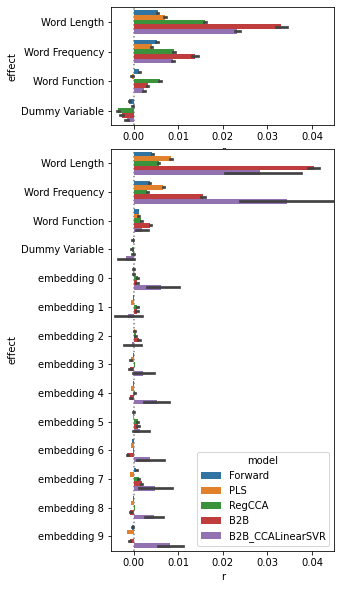

In [118]:
fig = plt.figure(figsize=[4, 10])
ax0 = plt.subplot(411)
ax1 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
data = get_all_results()
data = data.query('model!="Backward"')
sns.barplot(y='effect', x='r', orient='h',
            hue='model', data=data.query('time>0'), ax=ax0)
ax0.axvline(0, color='gray', ls=':', zorder=-1)
ax0.set_xlim(-.005, 0.045)
ax0.legend().set_visible(False)

data = get_all_results(word_emb=True)
data = data.query('model!="Backward"')
sns.barplot(y='effect', x='r', orient='h',
            hue='model', data=data.query('time>0'), ax=ax1)
ax1.axvline(0, color='gray', ls=':', zorder=-1)
ax1.set_xlim(-.005, 0.045)

fig.savefig('compare_embeddings.pdf', bbox_inches='tight')

In [113]:
features = ['Word Length', 'Word Frequency', 'Word Function', 'Dummy Variable']

Backward 93
Forward 93
PLS 93
RegCCA 93
B2B 93
B2B_CCALinearSVR 93


No handles with labels found to put in legend.


Word Length: Forward: 16.253992
Word Length: Forward versus B2B: 16.253992
Word Length: PLS: 16.253992
Word Length: PLS versus B2B: 16.253992
Word Length: RegCCA: 16.253992
Word Length: RegCCA versus B2B: 16.253992
Word Length: B2B: 16.253992
Word Length: B2B_CCALinearSVR: 16.253992


No handles with labels found to put in legend.


Word Length: B2B_CCALinearSVR versus B2B: 14.644062
Word Frequency: Forward: 16.253992
Word Frequency: Forward versus B2B: 16.253992
Word Frequency: PLS: 16.141169
Word Frequency: PLS versus B2B: 16.253992
Word Frequency: RegCCA: 16.253992
Word Frequency: RegCCA versus B2B: 8.265650
Word Frequency: B2B: 16.253992
Word Frequency: B2B_CCALinearSVR: 16.253992


No handles with labels found to put in legend.


Word Frequency: B2B_CCALinearSVR versus B2B: 13.006472
Word Function: Forward: 14.603913
Word Function: Forward versus B2B: 13.864846
Word Function: PLS: 1.574270
Word Function: PLS versus B2B: 16.056816
Word Function: RegCCA: 16.113026
Word Function: RegCCA versus B2B: 13.361769
Word Function: B2B: 16.056816
Word Function: B2B_CCALinearSVR: 10.725294


No handles with labels found to put in legend.


Word Function: B2B_CCALinearSVR versus B2B: 5.956456


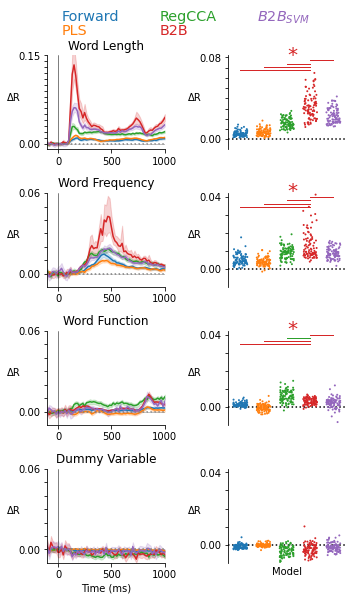

In [127]:
data = get_all_results()

data = data.query('model!="Backward" and model!="B2B_CCA"')
models = data.model.unique()

fig, axes = plt.subplots(4, 2, figsize=[5, 8])

for ax, effect in zip(axes[:, 0], features):
    sns.lineplot(x='time', y='r', hue='model', 
                 data=data.query('effect==@effect'),
                 ax=ax, legend=False)
    ax.axhline(0, color='gray', ls=':')

    ax.set_ylabel('ΔR').set_rotation(0)
    ax.axvline(0, color='k', lw=.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(effect)

    ylim = 0.06 if effect != 'Word Length' else 0.15
    ax.set_yticks(np.arange(0, ylim+.001, .01))
    ax.set_ylim(-.01, ylim)
    ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else ''
                           for f in np.arange(0, ylim+.001, .01)])
    ax.set_xlim(-100, 1000)
    ax.axhline(0, color='k', ls=':', zorder=-10, lw=.5)
    ax.set_xlabel('')
ax.set_xlabel('Time (ms)')

for feature, ax in zip(features, axes[:, 1]):
    d = data.query('effect==@feature and time>0 and time <1000')
    d = d.groupby(['subject', 'model'], as_index=False).mean()
    sns.stripplot(x='model', y='r', dodge=True, order=models,
                  s=2, jitter=.3, data=d, ax=ax)
    # legend clean up
    ax.axhline(0,color='k', ls=':')
    ax.legend().set_visible(False)
    ylim = 0.041 if feature != 'Word Length' else 0.081
    ax.set_ylim(-.01, ylim+0.001)
    ax.set_yticks(np.arange(0, ylim, .01))
    ytick_labels = ['%.2f' % f if f in np.around([0., ylim], 2) else '' 
                    for f in np.arange(0, ylim+.001, .01)]
    ax.set_yticklabels(ytick_labels)
    ax.set_ylabel('ΔR').set_rotation(0)
    ax.set_xticks([])
    ax.set_xlabel('')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # statistical comparison
    if feature == 'Dummy Variable':
        continue

    space = np.ptp(ax.get_ylim()) / 30
    k = 0
    for idx, m1 in enumerate(models):

        r = list()
        _, p = wilcoxon(d.query('model == @m1').r.values)
        print('%s: %s: %f' % (feature, m1, -np.log10(p)))
        
        for jdx, m2 in enumerate(models):
            if m1 == m2:
                continue
                
#             if not ((m2 == 'B2B' and feature in ('Dummy Variable', 'Word Length', 'Word Frequency'))
#                 or
#                 (m2 == 'RegCCA' and feature == 'Word Function')):
#                 continue
            if m2 != 'B2B':
                continue
            r = list()

            for _, subject in d.query('model in [@m1, @m2]').groupby('subject'):
                if len(subject)==2:
                    r.append([subject.query('model==@m1').r.values[0],
                              subject.query('model==@m2').r.values[0]])
            r1, r2 = np.transpose(r)
            valid = np.isfinite(r1) * np.isfinite(r2)
            u, p = wilcoxon(r1[valid], r2[valid])
            print('%s: %s versus %s: %f' % (feature, m1, m2, -np.log10(p)))
            if p < .05:
                k += 1
                y = .8 * ylim + k * space
                if np.median(r1) > np.median(r2):
                    color = 'C%i' % idx
                else:
                    color = 'C%i' % jdx
                    
                ax.plot(np.linspace(0, 4, 5)[[idx, jdx]], 
                        [y, y], color=color, lw=1.)
    ax.text(2, y, '*', color='C3', #if feature != 'Word Function' else 'C2'
            fontsize=20)
ax.set_xlabel('Model')

# legend
lines = [ax.plot([0, 0], [0,0], color='C%i' % i)[0] for i in range(5)]
#lines = [ax.plot([0, 0], [0,0], color='w')[0]] + lines
names = [m if m != 'B2B_CCALinearSVR' else '$B2B_{SVM}$' for m in models]
leg = plt.figlegend(lines, names, loc='upper center', 
                    ncol=3, labelspacing=0., fontsize='x-large',
                    handlelength=0, frameon=False,
                    bbox_to_anchor=(0.5,1.05))

for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

fig.tight_layout()
fig.savefig('meg.pdf', bbox_inches='tight')

Backward 93
Forward 93
PLS 93
RegCCA 93
B2B 93
B2B_CCALinearSVR 93


Text(0.5, 0, 'Time (ms)')

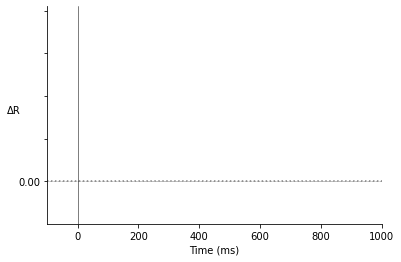

In [121]:
data = get_all_results()

fig, ax = plt.subplots(1)
sns.lineplot(x='time', y='r', hue='effect', 
             data=data.query('model=="Backward"'),
             legend=False)
ax.axhline(0, color='gray', ls=':')

ax.set_ylabel('ΔR').set_rotation(0)
ax.axvline(0, color='k', lw=.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks(np.arange(0, ylim+.001, .01))
ax.set_ylim(-.01, ylim)
ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else ''
                       for f in np.arange(0, ylim+.001, .01)])
ax.set_xlim(-100, 1000)
ax.axhline(0, color='k', ls=':', zorder=-10, lw=.5)
ax.set_xlabel('Time (ms)')
